In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchxai.base import XaiBase, XaiHook, XaiModel
from collections import OrderedDict
from src.models import CnnMnist, ResNetMnist, ResNetMnistCBAM, ResNetMnistANR, ResNetCifar10, ResNetCifar10CBAM, ResNetCifar10ANR
from torchxai.model import VanillaGrad
import matplotlib.pyplot as plt

In [2]:
from src.trainsettings import ModelTranier
from src.utils import argument_parsing

In [3]:
parser = argument_parsing(preparse=True)
args_string = \
"""-pp  ../XAI
-dp  ../data
-rf  cifar10-resnet-roar
-dt  cifar10
-et  roar
-at  vanillagrad  inputgrad  guidedgrad  gradcam
-mt  resnet  resnetcbam  resnetanr
-bs  256
-ns  10
-rcd  mean
-sd  73""".replace("\n", "  ").split("  ")
args = parser.parse_args(args_string)
trainer = ModelTranier()

In [4]:
torch.manual_seed(args.seed)
train_dataset, test_dataset, train_loader, test_loader = trainer.build_dataset(args, shuffle=False)

In [12]:
m_type = "resnet"
a_type = "inputgrad"
load_path = "trained/cifar10/roar/resnet-first.pt"
model_class = trainer.model_dict[args.data_type][m_type]
attr_class = trainer.attr_dict[a_type]
# attr_class = GradCAM
attr_kwargs = trainer.get_kwargs_to_attr_model(args.data_type, m_type, a_type)
model, attr_model = trainer.create_attr_model(model_class, attr_class, load_path, attr_kwargs)
# model = ResNetMnist()
# attr_model = trainer.attr_dict[a_type](model)

In [13]:
from torchvision import transforms
import numpy as np
inv_normalize = transforms.Normalize(
                mean=[-0.4914/0.2470, -0.4822/0.2435, -0.4465/0.2616],
                std=[1/0.2470, 1/0.2435, 1/0.2616]
            )
tf = transforms.Compose([
    inv_normalize, 
    transforms.ToPILImage()
])
tf2 = transforms.Compose([
    transforms.ToPILImage()
]) 
inv_transform = lambda tensor: torch.ByteTensor([np.array(tf(x)) for x in tensor])
inv_transform_output = lambda tensor: torch.ByteTensor([np.array(tf2(x)) for x in tensor])
del_p = 0.2

In [14]:
def calculate_masks(args, outputs, del_p):
    B, C, H, W = outputs.size()
    # outputs, C = trainer.convert_scale(args, outputs, C)
    reshaped_outputs = outputs.view(B, C, -1)
    vals, _ = reshaped_outputs.sort(-1, descending=True)
    # decide how many pixels to delete
    del_n_idx = torch.LongTensor([int(del_p * H * W)])  
    del_vals = vals.index_select(-1, del_n_idx)
    del_masks = (reshaped_outputs >= del_vals).view(B, C, H, W)
    return del_masks

In [15]:
# B, C, H, W = outputs.size()
# # outputs, C = trainer.convert_scale(args, outputs, C)
# reshaped_outputs = outputs.view(B, C, -1)
# vals, _ = reshaped_outputs.sort(-1, descending=True)
# # decide how many pixels to delete
# del_n_idx = torch.LongTensor([int(del_p * H * W)])  
# del_vals = vals.index_select(-1, del_n_idx)
# del_masks = (reshaped_outputs >= del_vals).view(B, C, H, W)

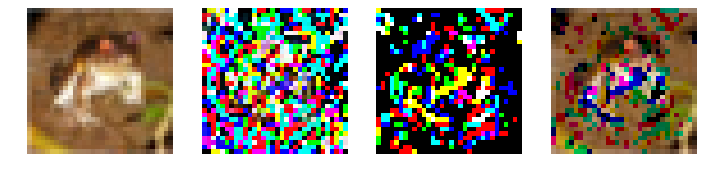

In [16]:
for datas, targets in train_loader:
    outputs = attr_model.get_attribution(datas, targets).detach()
    masks = calculate_masks(args, outputs, del_p)
    break

inv_datas = inv_transform(datas)
inv_outputs = inv_transform_output(outputs)
temp = inv_datas.permute(0, 3, 1, 2).masked_fill(masks, 0.0)

a = inv_datas[0]
b = inv_outputs[0]
c = masks[0].permute(1, 2, 0).float()
d = temp[0].permute(1, 2, 0)

fig, axes = plt.subplots(1, 4, figsize=(12, 6))
for ax, x in zip(axes, [a, b, c, d]):
    ax.imshow(x)
    ax.axis("off")
plt.show()

reduce dimension

In [17]:
def calculate_masks(args, outputs, del_p):
    B, C, H, W = outputs.size()
    outputs, C = trainer.convert_scale(args, outputs, C)
    reshaped_outputs = outputs.view(B, C, -1)
    vals, _ = reshaped_outputs.sort(-1, descending=True)
    # decide how many pixels to delete
    del_n_idx = torch.LongTensor([int(del_p * H * W)])  
    del_vals = vals.index_select(-1, del_n_idx)
    del_masks = (reshaped_outputs >= del_vals).view(B, C, H, W)
    return del_masks

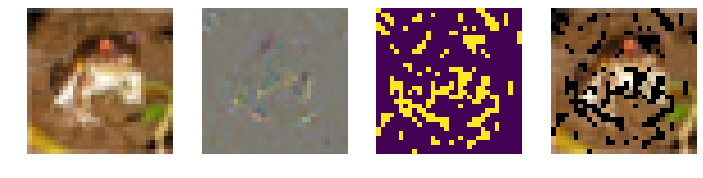

In [18]:
for datas, targets in train_loader:
    outputs = attr_model.get_attribution(datas, targets).detach()
    masks = calculate_masks(args, outputs, del_p)
    break
    
inv_datas = inv_transform(datas)
inv_outputs = inv_transform(outputs)
temp = inv_datas.permute(0, 3, 1, 2).masked_fill(masks, 0)

a = inv_datas[0]
b = inv_outputs[0]
c = masks[0].squeeze()
d = temp[0].permute(1, 2, 0)

fig, axes = plt.subplots(1, 4, figsize=(12, 6))
for ax, x in zip(axes, [a, b, c, d]):
    ax.imshow(x)
    ax.axis("off")
plt.show()

---

In [11]:
from torchxai.model import GradCAM, DeconvNet, VanillaGrad, InputGrad, GuidedGrad, LRP
import matplotlib.pyplot as plt

In [12]:
kwargs_packs = {
    "mnist": {
        "gradcam": {
            "cnn": dict(layers_name=None, norm_mode=1),
            "resnet": dict(layers_name="relu_last", norm_mode=1),
            "resnetcbam": dict(layers_name="relu_last", norm_mode=1)
        },
        "guidedgrad": {
            "cnn": dict(act=nn.ReLU),
            "resnet": dict(act=nn.ReLU),
            "resnetcbam": dict(act=nn.ReLU)
        },
        "relavance": {
            "cnn": dict(use_rho=False)
        },
        "deconv": {
            "cnn": dict(module_name="convs")
        }, 
        "vanillagrad": None, 
        "inputgrad": None
    },
    "cifar10": {
        "gradcam": {
            "resnet": dict(layers_name="relu_last", norm_mode=3),
            "resnetcbam": dict(layers_name="relu_last", norm_mode=3)
        },
        "guidedgrad": {
            "resnet": dict(act=nn.ReLU),
            "resnetcbam": dict(act=nn.ReLU)
        },
        "vanillagrad": None, 
        "inputgrad": None
    }
}

def get_kwargs(data_type, a_type, m_type, kwargs_packs):
    pre_kwargs = kwargs_packs[data_type].get(a_type)
    if pre_kwargs is not None:
        kwargs = pre_kwargs.get(m_type)
    else:
        kwargs = {"<none>": None}
    return kwargs

In [13]:
data_type = "mnist"
x = torch.randn(1, 1, 28, 28)
targets = torch.LongTensor([2])

## GradCAM

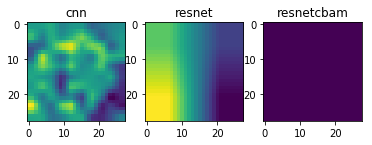

In [17]:
figure, axes = plt.subplots(1, 3)
a_type = "gradcam"
for m_type, m, ax in zip(["cnn", "resnet", "resnetcbam"], 
                         [model, model2, model3], axes):
    kwargs = get_kwargs(data_type, a_type, m_type, kwargs_packs)
    gradcam_model = GradCAM(m, **kwargs)
    gradcam = gradcam_model.get_attribution(x, targets)
    ax.imshow(gradcam.squeeze())
    ax.set_title(m_type)
plt.show()

## GuidedGrad

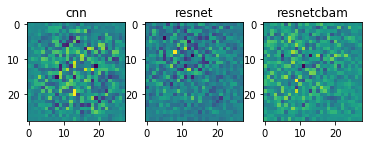

In [18]:
figure, axes = plt.subplots(1, 3)
a_type = "guidedgrad"
for m_type, m, ax in zip(["cnn", "resnet", "resnetcbam"], 
                         [model, model2, model3], axes):
    kwargs = get_kwargs(data_type, a_type, m_type, kwargs_packs)
    guided_model = GuidedGrad(m, **kwargs)
    grad = guided_model.get_attribution(x, targets)
    ax.imshow(grad.squeeze())
    ax.set_title(m_type)
plt.show()

## VanillaGrad

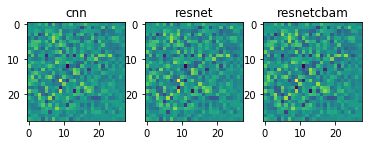

In [19]:
figure, axes = plt.subplots(1, 3)
a_type = "vanillagrad"
for m_type, m, ax in zip(["cnn", "resnet", "resnetcbam"], 
                         [model, model2, model3], axes):
    kwargs = get_kwargs(data_type, a_type, m_type, kwargs_packs)
    vanillagrad = VanillaGrad(m, **kwargs)
    grad = guided_model.get_attribution(x, targets)
    ax.imshow(grad.squeeze())
    ax.set_title(m_type)
plt.show()

## InputGrad

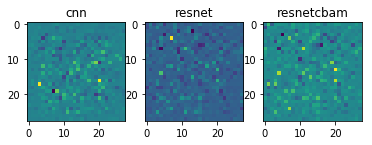

In [21]:
figure, axes = plt.subplots(1, 3)
a_type = "inputgrad"
for m_type, m, ax in zip(["cnn", "resnet", "resnetcbam"], 
                         [model, model2, model3], axes):
    kwargs = get_kwargs(data_type, a_type, m_type, kwargs_packs)
    gradinput = InputGrad(m, **kwargs)
    grad = gradinput.get_attribution(x, targets)
    ax.imshow(grad.squeeze())
    ax.set_title(m_type)
plt.show()

## DeconvNet

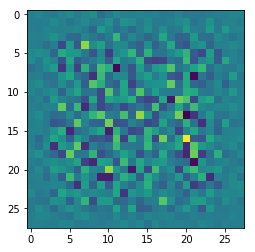

In [22]:
a_type = "deconv"
m_type = "cnn"
kwargs = get_kwargs(data_type, a_type, m_type, kwargs_packs)
deconvnet = DeconvNet(model, **kwargs)
deconv = deconvnet.get_attribution(x, targets)
plt.imshow(deconv.squeeze())
plt.show()

## LRP

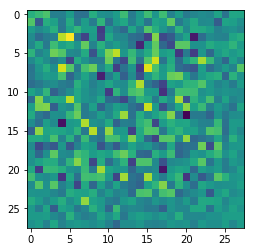

In [24]:
lrp_model = LRP(model)
lrp = lrp_model.get_attribution(x, targets)
plt.imshow(lrp.squeeze())
plt.show()